# Disaster Tweets

https://www.kaggle.com/competitions/nlp-getting-started/data?select=sample_submission.csv

# Importing Packages

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim as gs
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay,roc_auc_score,plot_roc_curve,mean_squared_error,roc_curve
from sklearn.linear_model import LogisticRegression,Lasso
import warnings



# Importing Dataset

In [476]:
# Importing Training dataset
train_dataset = pd.read_csv('train.csv')

# Importing Test dataset
test_dataset = pd.read_csv('test.csv')


In [482]:
train_dataset.merge(test_dataset)

,id,keyword,location,text,target


# Initial EDA

In [434]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [435]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


#### Data explanation from the source

**id** - a unique identifier for each tweet \
**text** - the text of the tweet \
**location** - the location the tweet was sent from (may be blank) \
**keyword** - a particular keyword from the tweet (may be blank) \
**target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0) 

In [436]:
# Visualising the table 
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [437]:
# Dropping the unique identifier from the training dataset
train_dataset = train_dataset.drop(columns = 'id')

In [438]:
# Checking for duplicates
train_dataset.duplicated().sum()

52

In [439]:
# Checking the duplicated cases. 
train_dataset[train_dataset.duplicated() == True]

,keyword,location,text,target
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
119,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
164,airplane%20accident,NaN,Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wednesday began examining t...,1
630,bioterrorism,NaN,To fight bioterrorism sir.,1
634,bioterrorism,NaN,To fight bioterrorism sir.,0
2352,demolition,NaN,General News Û¢åÊ'Demolition of houses on waterways begins at Achimota Mile 7 ' via @233liveOnline. Full story at http://t.co/iO7kUUg1uq,0
2452,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,1
2454,derailment,India,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,1
2456,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,1


### Missing values

#### Feature Missing Values

In [440]:
# Training dataset
train_dataset.isnull().sum()/len(train_dataset)

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [441]:
# Test dataset
test_dataset.isnull().sum()/len(test_dataset)

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

Missing values seen in both keyword and location. Similar proportions missing in test and training datasets

In [442]:
# Checking if the data is missing at a similar rate for target = 0 and target = 1
train_dataset[train_dataset.target == 0].notnull().mean()

keyword     0.995624
location    0.664210
text        1.000000
target      1.000000
dtype: float64

In [443]:
train_dataset[train_dataset.target == 1].notnull().mean()

keyword     0.987160
location    0.671354
text        1.000000
target      1.000000
dtype: float64

Similar proportion between the between Disaster and Non disaster tweets

## Target Analysis

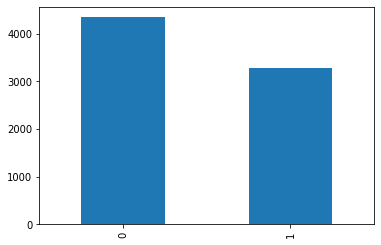

In [444]:
train_dataset.target.value_counts().plot(kind = 'bar')

Rather balanced dataset

In [445]:
train_dataset.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Feature Analysis

In [446]:
# Checking what keywords have the higher precision in terms of disaster tweets
keyword_groupby_target_mean=train_dataset.groupby('keyword').mean().sort_values(by = 'keyword', ascending = False)
keyword_groupby_target_sum=train_dataset.groupby('keyword').sum().sort_values(by = 'keyword', ascending = False)
keyword_groupby_target_mean['sum_of_target'] = keyword_groupby_target_sum.target.values
keyword_groupby_target_mean.sort_values(by = 'sum_of_target', ascending = False).head(20)

,target,sum_of_target
keyword,,
wreckage,1.000000,39
derailment,1.000000,39
outbreak,0.975000,39
oil%20spill,0.973684,37
debris,1.000000,37
typhoon,0.973684,37
suicide%20bomb,0.914286,32
rescuers,0.914286,32
suicide%20bombing,0.969697,32


In [447]:
# Checking rows that have a null keyword. 
pd.set_option('display.max_colwidth', None)
train_dataset[train_dataset.keyword.isnull() == True].head(5)

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


We can see from the dataframe above, that certain tweets with words containing some "high risk" words such as Fire do not have a keyword populated. If we then actually check if the keyword Fire exists, we can see that it does. One possibility would be to take the keywords with the highest precision and see if the keyword actually exists in the text, and then impute it.

In [448]:
train_dataset[train_dataset.keyword.isin(['fire']) == True].head(5)

,keyword,location,text,target
3738,fire,NaN,Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy,0
3739,fire,SÌ£o Paulo,Marquei como visto Game of Thrones - 3x5 - Kissed by Fire http://t.co/CJHH17duli #bancodeseries,0
3740,fire,NaN,Save the Date! Saturday August 15 2015 is the Salisbury Fire Department Open House at 325 Cypress St 10am to... http://t.co/Oa6B0Z2H6Y,0
3741,fire,NaN,Why put out a fire when it's still burning.,0
3742,fire,2 high 2 come down,@Miss_HoMaStToPa cause were on fire we are on fire were on fire now.. Yeah were on fire we are on fire were on fire nowwwwww,1


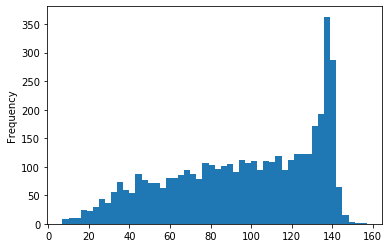

In [449]:
# Checking length of tweet between disaster and non-disaster tweets.
train_dataset[train_dataset.target == 0].text.apply(lambda x : len(x)).plot(kind = 'hist', bins = 50)

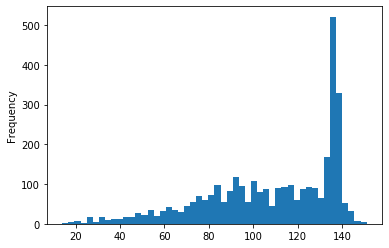

In [450]:
train_dataset[train_dataset.target == 1].text.apply(lambda x : len(x)).plot(kind = 'hist', bins = 50)

# Data Cleaning

In [451]:
# Replacing the NaNs in the columns keyword and location with a level called missing for simplicity. 
train_dataset['keyword'] = train_dataset.keyword.replace(np.NaN,'missing')
train_dataset['location'] = train_dataset.location.replace(np.NaN,'missing')

# Model Building

## Data Preprocessing

**CAUTION** : 

The Word2Vec model will be trained on the full conctenation of the training and test dataset. This of course may present a data leakage issue, but due to this being the first NLP project, we will proceed with this approach. 


In [495]:
train_dataset_without_target = train_dataset.drop(columns = 'target')
concat_df = [train_dataset_without_target,test_dataset]
full_dataset = pd.concat(concat_df)

In [522]:
# Cleaning the text string and tokenizing the string. Preparing the datasets for modelling

# The full dataset which will be used to train the Word2Vec model
full_dataset['text_preprocessed'] = full_dataset['text'].apply(lambda x: simple_preprocess(x))
full_dataset_modelling = full_dataset.copy()
full_dataset_modelling = full_dataset_modelling.drop(columns = ['keyword','location','text','id'])

# Training dataset which will be used to train the classification model
train_dataset['text_preprocessed'] = train_dataset['text'].apply(lambda x: simple_preprocess(x))
train_dataset_modelling = train_dataset.copy()
train_dataset_modelling_target = train_dataset_modelling.target
train_dataset_modelling = train_dataset.drop(columns = ['keyword','location','text','target','id'])
train_dataset_modelling_features = train_dataset_modelling.text_preprocessed

# Test dataset which will be predicted. 
test_dataset['text_preprocessed'] = test_dataset['text'].apply(lambda x: simple_preprocess(x))
test_dataset_modelling = test_dataset.copy()
test_dataset_modelling = test_dataset_modelling.drop(columns = ['keyword','location','text','id'])

## Word2Vec Model Training


In [513]:
vector_size_embedding = 50
w2v_model = Word2Vec(full_dataset_modelling,vector_size=vector_size_embed,window=10,min_count=1)

In [524]:
# For the following 2 cells, borrowing the code from this page as its the first time doing a NLP classifcation case
# https://michael-fuchs-python.netlify.app/2021/09/01/nlp-word-embedding-with-gensim-for-text-classification/

# All words in the embedded matrix
words = set(w2v_model.wv.index_to_key )


train_dataset_modelling['Text_vect'] = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in train_dataset_modelling['text_preprocessed']])

test_dataset_modelling['Text_vect'] = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in test_dataset_modelling['text_preprocessed']])

ValueError: Wrong number of items passed 0, placement implies 1

In [506]:
set(w2v_model.wv.index_to_key )

{'kristy',
 'quezon',
 'qew',
 'specs',
 'kvzuxdl',
 'ipv',
 'your',
 'jirxfok',
 'hhwv',
 'jackson',
 'ezqgg',
 'print',
 'poured',
 'hostages',
 'ensures',
 'manchester',
 'jfjlbf',
 'sputnik',
 'kady',
 'uncertainty',
 'txtpx',
 'isil',
 'yfavsuogvl',
 'zqkxg',
 'xpvkqme',
 'riders',
 'wloctevc',
 'nevaehburton',
 'wants',
 'grande',
 'eerie',
 'cmghxba',
 'lbkvfqrpgt',
 'yvo',
 'epz',
 'crusad',
 'szi',
 'aborted',
 'collideworship_',
 'underground',
 'paging',
 'clown',
 'imposition',
 'shes',
 'homegrown',
 'aqmpxzo',
 'stephenscifi',
 'aljwawkxpj',
 'skinson',
 'fall',
 'dhgavw',
 'liveonkbak',
 'weaknesses',
 'submarines',
 'species',
 'manyvids',
 'recovers',
 'netanyahu',
 'amirkingkhan',
 'wxces',
 'ifm',
 'asad',
 'expose',
 'nycha',
 'qmgpb',
 'hjj',
 'grumpout',
 'aog',
 'followers',
 'zyttg',
 'sods',
 'royale',
 'rly',
 'zw',
 'ongoing',
 'cuana',
 'jerusalem_post',
 'anna',
 'nebmwy',
 'wkv',
 'addiction',
 'mwzqcjhzpb',
 'indiahttp',
 'zzka',
 'rogers',
 'azovgv',
 'd

In [502]:
text_vect_avg = []
for v in train_dataset_modelling['Text_vect']:
    if v.size:
        text_vect_avg.append(v.mean(axis=0))
    else:
        text_vect_avg.append(np.zeros(vector_size_embedding, dtype=float))
        
        
train_dataset_modelling['Text_vect_avg'] = text_vect_avg

In [503]:
text_vect_avg_dataframe=pd.DataFrame(text_vect_avg)

new_columns = list()
for i in text_vect_avg_dataframe.columns:
    new_column_name = f"Dimension_{i}"
    new_columns.append(new_column_name)
text_vect_avg_dataframe.columns = new_columns

In [504]:
train
x_train, x_validation, y_train, y_validation = train_test_split(text_vect_avg_dataframe,train_dataset.target, test_size = 0.2)

ValueError: Found input variables with inconsistent numbers of samples: [10876, 7613]

## Classification Model Training

In [460]:
# Defining a random forest classifer 
random_forest = RandomForestClassifier()
random_forest.fit(x_train,y_train)

# Defining a AdaBoost classifier 
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train,y_train)

# Defining a logistic regression lasso classifier 
logistic_regression_lasso = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 1000, C = 1)
logistic_regression_lasso.fit(x_train,y_train)

# Defining a logistic regression elastic net classifier 
logistic_regression_elastic_net = LogisticRegression(penalty = 'elasticnet', solver='saga', l1_ratio = 0.5, max_iter = 1000)
logistic_regression_elastic_net.fit(x_train,y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [461]:
predicted_probabilities_validation_rf = random_forest.predict_proba(x_validation)[:,1]
predicted_probabilities_validation_ab = ada_boost.predict_proba(x_validation)[:,1]
predicted_probabilities_validation_lasso = logistic_regression_lasso.predict_proba(x_validation)[:,1]
predicted_probabilities_validation_elastic = logistic_regression_elastic_net.predict_proba(x_validation)[:,1]

In [462]:
roc_auc_rf = roc_auc_score(y_validation,predicted_probabilities_validation_rf)
roc_auc_ab = roc_auc_score(y_validation,predicted_probabilities_validation_ab)
roc_auc_lasso = roc_auc_score(y_validation,predicted_probabilities_validation_lasso)
roc_auc_elastic_net = roc_auc_score(y_validation,predicted_probabilities_validation_elastic)

In [463]:
roc_auc_rf,roc_auc_ab,roc_auc_lasso,roc_auc_elastic_net

(0.7176749018702379, 0.717444882908979, 0.7613889996711516, 0.7351808316366155)

Text(0, 0.5, 'True Positive Rate')

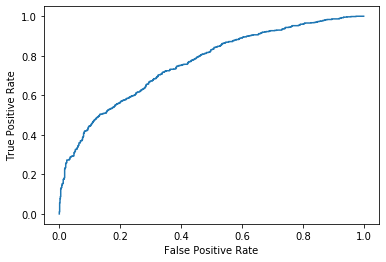

In [466]:
fpr, tpr, _ = roc_curve(y_validation, predicted_probabilities_validation_lasso)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Hyperparameter Tuning

In [403]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_search = GridSearchCV(cv=None,
             estimator=LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 100 , C = 1),
             param_grid={'C': [1,10,100,200]})
warnings.warn("once")
grid_search.fit(x_train,y_train)


/Users/michael.troyanovsky/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/michael.troyanovsky/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/michael.troyanovsky/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/michael.troyanovsky/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/michael.troyanovsky/Library/Python/3.7/lib/python/site-packag

GridSearchCV(estimator=LogisticRegression(C=1, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': [1, 10, 100, 200]})

In [407]:
c_value_tuned = grid_search.best_params_['C']

In [467]:
# Training a Logistic Regression model with the new C value (which is the inverse of the alpha value used in Lasso regression)
# Model is trained on the full dataset. 
logistic_regression_lasso_tuned = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 500, C = 10)
logistic_regression_lasso_tuned.fit(text_vect_avg_dataframe,target_data)

LogisticRegression(C=10, max_iter=500, penalty='l1', solver='liblinear')

In [468]:
predicted_probabilities_final_model=logistic_regression_lasso_tuned.predict_proba(text_vect_avg_dataframe)[:,1]
roc_auc_score(target_data,predicted_probabilities_final_model)

0.7746401348703013

In [470]:
test_dataset = test_dataset.drop(columns = ['id','keyword','location'])

In [471]:
test_dataset

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone."
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [473]:
X_test_dtm = w2v_model.transform(test_dataset)

AttributeError: 'Word2Vec' object has no attribute 'transform'

In [505]:
text_vect_avg_dataframe

,Dimension_0,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,...,Dimension_40,Dimension_41,Dimension_42,Dimension_43,Dimension_44,Dimension_45,Dimension_46,Dimension_47,Dimension_48,Dimension_49
0,0.153159,-0.736207,-0.003443,-0.110179,0.012430,-1.926172,1.038914,1.898242,-1.648300,-0.655333,...,1.740107,-0.375283,-0.158124,0.317967,1.471940,0.243454,0.249013,-1.198136,0.734506,0.660154
1,-0.054118,-0.416101,-0.035052,0.035680,0.003188,-1.175353,0.822624,1.091562,-0.985059,-0.210724,...,0.812947,-0.200444,-0.171446,0.140088,0.825388,0.263425,-0.005416,-0.579625,0.386612,0.399815
2,0.077522,-0.677146,-0.051698,-0.055388,0.027196,-1.802886,1.028848,1.761634,-1.526675,-0.522332,...,1.540435,-0.350426,-0.172422,0.277575,1.341457,0.238024,0.168871,-1.059378,0.669540,0.623119
3,-0.075091,-0.516542,-0.081938,0.043347,0.017223,-1.580247,1.063723,1.431969,-1.302383,-0.278844,...,1.101218,-0.266749,-0.243845,0.164591,1.082872,0.359041,-0.003700,-0.795342,0.522616,0.517519
4,0.073333,-0.716092,-0.019058,-0.044363,0.018940,-1.944115,1.172263,1.871448,-1.645697,-0.516134,...,1.589414,-0.344640,-0.198713,0.305333,1.459478,0.288896,0.140210,-1.115458,0.688729,0.688701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,-0.053401,-0.193349,-0.034196,0.023869,0.013792,-0.612083,0.429817,0.550294,-0.508795,-0.086151,...,0.408099,-0.113448,-0.093660,0.061684,0.418193,0.142096,-0.023926,-0.288339,0.209252,0.213927
10872,0.154164,-0.688261,0.010782,-0.083129,0.005123,-1.764468,0.962499,1.765480,-1.559678,-0.605963,...,1.594504,-0.360402,-0.136549,0.306570,1.365869,0.194754,0.236676,-1.109862,0.653249,0.626258
10873,-0.420037,-0.593886,-0.212117,0.324036,-0.000321,-2.387604,1.933689,1.949677,-1.831186,-0.050794,...,1.124016,-0.359492,-0.557814,0.049350,1.446959,0.739757,-0.387455,-0.834228,0.744033,0.846608
10874,-0.370856,-0.426218,-0.168812,0.272151,-0.003114,-1.767792,1.481761,1.425622,-1.334269,0.025870,...,0.765788,-0.273643,-0.442266,0.001628,1.041901,0.563892,-0.336724,-0.549024,0.539401,0.630659
